In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Functions and Variables from getMobilityData.py
from getMobilityData import load_fips_codes
from getMobilityData import download_google_mobility_data, load_google_mobility_data
from getMobilityData import download_weekly_county_data, load_weekly_county_data

# Global Variables
DATA_FOLDER_PATH = os.path.join(os.pardir, 'data')

## FIPS Codes

In [2]:
file_path = os.path.join(DATA_FOLDER_PATH, os.path.join('FIPS_codes', 'fips_codes.txt'))

# Load the FIPS code data
state_codes_df, county_codes_df = load_fips_codes(file_path=file_path)

# Convert codes to ints
state_codes_df['code'] = state_codes_df['code'].astype(int)
county_codes_df['code'] = county_codes_df['code'].astype(int)

# Display the county codes
display(county_codes_df.head())

,code,county
0,1000,Alabama
1,1001,Autauga County
2,1003,Baldwin County
3,1005,Barbour County
4,1007,Bibb County


## Google Mobility Data

In [28]:
# Output folder for google mobility data
#output_folder=os.path.join(DATA_FOLDER_PATH, 'google_mobility_data')

# Ensure the directory exists
#if(os.path.exists(output_folder) == False):
#    os.makedirs(output_folder)

In [3]:
# Download the data
#download_google_mobility_data(output_folder=output_folder)

In [2]:
output_folder = os.path.join(DATA_FOLDER_PATH, 'google_mobility_data')
file_path = os.path.join(DATA_FOLDER_PATH, os.path.join('Cleaned_mobility_data', 'google_mobility_data.csv'))

# Load the data
google_mobility_data = load_google_mobility_data(data_path=output_folder)
display(google_mobility_data)

,date,country_code,country,state,county,retail_and_recreation_percent_change,grocery_and_pharmacy_percent_change,parks_percent_change,transit_stations_percent_change,workplaces_percent_change,residential_percent_change,place_id,census_fips_code
0,2020-02-15,US,United States,Alabama,Autauga County,5.0,7.0,NaN,NaN,-4.0,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,1001.0
1,2020-02-16,US,United States,Alabama,Autauga County,0.0,1.0,-23.0,NaN,-4.0,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,1001.0
2,2020-02-17,US,United States,Alabama,Autauga County,8.0,0.0,NaN,NaN,-27.0,5.0,ChIJg9z7ewWPjogRA_8QrB0va7o,1001.0
3,2020-02-18,US,United States,Alabama,Autauga County,-2.0,0.0,NaN,NaN,2.0,0.0,ChIJg9z7ewWPjogRA_8QrB0va7o,1001.0
4,2020-02-19,US,United States,Alabama,Autauga County,-2.0,0.0,NaN,NaN,2.0,0.0,ChIJg9z7ewWPjogRA_8QrB0va7o,1001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461341,2022-10-10,US,United States,Wyoming,Weston County,NaN,NaN,NaN,NaN,-26.0,NaN,ChIJd4Rqhed3YocR7ubT5-HgoJg,56045.0
2461342,2022-10-11,US,United States,Wyoming,Weston County,NaN,NaN,NaN,NaN,-20.0,NaN,ChIJd4Rqhed3YocR7ubT5-HgoJg,56045.0
2461343,2022-10-12,US,United States,Wyoming,Weston County,NaN,NaN,NaN,NaN,-17.0,NaN,ChIJd4Rqhed3YocR7ubT5-HgoJg,56045.0
2461344,2022-10-13,US,United States,Wyoming,Weston County,NaN,NaN,NaN,NaN,-15.0,NaN,ChIJd4Rqhed3YocR7ubT5-HgoJg,56045.0


In [16]:
# Get the NY data
google_mobility_data_NY = google_mobility_data[google_mobility_data['state'] == 'New York']

# Drop some columns
google_mobility_data_NY.drop(columns=['country_code', 'country', 'state', 'place_id'], inplace=True)

# Limit the date range
google_mobility_data_NY['date'] = pd.to_datetime(google_mobility_data_NY['date'])

# Forward-fill missing values for each county
for county in np.unique(google_mobility_data_NY['county']):
    google_mobility_data_NY[google_mobility_data_NY['county'] == county] = google_mobility_data_NY[google_mobility_data_NY['county'] == county].ffill(inplace=False)

# Replace the remaining NaN with zero
google_mobility_data_NY = google_mobility_data_NY.replace(np.nan, 0)

# Average using sunday to next saturday
google_mobility_data_NY = google_mobility_data_NY.groupby([pd.Grouper(key='date', freq='W-SAT'), 'county', 'census_fips_code']).mean().reset_index()

# Make fips codes integers
google_mobility_data_NY['census_fips_code'] = google_mobility_data_NY['census_fips_code'].astype(int)

# Ensure every county has data for all the dates
county_data_list = []
for county in google_mobility_data_NY['county'].unique():
    if(google_mobility_data_NY[google_mobility_data_NY['county'] == county]['date'].shape[0] < 140):
        county_data = google_mobility_data_NY[google_mobility_data_NY['county'] == county].merge(google_mobility_data_NY[google_mobility_data_NY['county'] == 'Albany County']['date'], how='right', on='date').ffill()
    else:
        county_data = google_mobility_data_NY[google_mobility_data_NY['county'] == county]
    county_data_list.append(county_data)
    
google_mobility_data_NY = pd.concat([x for x in county_data_list])

# Display the data
display(google_mobility_data_NY)

# Save as CSV
google_mobility_data_NY.to_csv(os.path.join(DATA_FOLDER_PATH, os.path.join('Cleaned_mobility_data', 'google_mobility_data.csv')))

,date,county,census_fips_code,retail_and_recreation_percent_change,grocery_and_pharmacy_percent_change,parks_percent_change,transit_stations_percent_change,workplaces_percent_change,residential_percent_change
0,2020-02-15,Albany County,36001.0,8.000000,-4.000000,45.000000,4.000000,0.000000,0.000000
61,2020-02-22,Albany County,36001.0,3.857143,-3.571429,-1.285714,-1.000000,-9.857143,2.428571
122,2020-02-29,Albany County,36001.0,6.428571,1.857143,28.428571,5.285714,3.285714,-0.571429
183,2020-03-07,Albany County,36001.0,8.428571,12.285714,29.000000,5.571429,4.000000,-0.571429
244,2020-03-14,Albany County,36001.0,0.285714,19.571429,54.000000,-1.571429,-0.857143,1.428571
...,...,...,...,...,...,...,...,...,...
135,2022-09-17,Yates County,36123.0,-33.000000,34.142857,0.000000,0.000000,-20.000000,0.571429
136,2022-09-24,Yates County,36123.0,-33.000000,32.142857,0.000000,0.000000,-19.142857,1.714286
137,2022-10-01,Yates County,36123.0,-33.000000,30.142857,0.000000,0.000000,-18.714286,2.142857
138,2022-10-08,Yates County,36123.0,-33.000000,33.000000,0.000000,0.000000,-18.571429,2.000000


## GeoDS Mobility Data

### Weekly County Data

In [32]:
output_folder =os.path.join(DATA_FOLDER_PATH, os.path.join('GeoDS_county_data', 'weekly'))
file_path = os.path.join(output_folder, 'weekly_county_data.csv')

# Make sure the output path exists
if(os.path.exists(output_folder) == False):
    os.makedirs(output_folder)

In [33]:
# NOTE: This downloads the data. May take 10+ minutes to download data
# So leave commented if you already have the data
# NOTE: Start and end dates must be mondays for weekly data. 
'''
start_date = '01/06/2020'
end_date = '12/27/2021'
        
# Download NC weekly county data
download_weekly_county_data(start_date, end_date, output_folder=output_folder, valid_fips=NY_county_fip_codes)
'''

"\nstart_date = '01/06/2020'\nend_date = '12/27/2021'\n        \nNY_county_fip_codes = set(np.arange(36001, 36124, 2))\n\n# Download NC weekly county data\ndownload_weekly_county_data(start_date, end_date, output_folder=output_folder, valid_fips=NY_county_fip_codes)\n"

In [34]:
# Load the data
geoDS_weekly_county_df = load_weekly_county_data(file_path=file_path)
#display(geoDS_weekly_county_df)

In [35]:
# Remove some unnecessary columns
geoDS_weekly_county_NY = geoDS_weekly_county_df.drop(columns=['lng_o', 'lat_o', 'lng_d', 'lat_d', 'visitor_flows'])

# Clean Date column
geoDS_weekly_county_NY['date'] = geoDS_weekly_county_NY['date_range'].str.split('-', expand=True)[1]
geoDS_weekly_county_NY['date'] = pd.to_datetime(geoDS_weekly_county_NY['date']) - pd.DateOffset(1)

# Calculate inflow
NY_fips_codes = set(np.arange(36001, 36124, 2))
inflows_df = geoDS_weekly_county_NY[geoDS_weekly_county_NY['geoid_d'].isin(NY_fips_codes)]
inflows_df = inflows_df.drop(columns=['date_range', 'geoid_o'], inplace=False)
inflows_df = inflows_df.groupby(['date', 'geoid_d']).sum().reset_index()
inflows_df = inflows_df.rename(columns={'pop_flows':'inflow', 'geoid_d':'fips_code'})

# Calculate the outflows
outflows_df = geoDS_weekly_county_NY[geoDS_weekly_county_NY['geoid_o'].isin(NY_fips_codes)]
outflows_df = outflows_df.drop(columns=['date_range', 'geoid_d'], inplace=False)
outflows_df = outflows_df.groupby(['date', 'geoid_o']).sum().reset_index()
outflows_df = outflows_df.rename(columns={'pop_flows':'outflow', 'geoid_o':'fips_code'})

# Merge the inflows and outflows
geoDS_weekly_county_NY = inflows_df.merge(outflows_df, on=['date', 'fips_code'], how='inner')

# Put names to fips codes
geoDS_weekly_county_NY = geoDS_weekly_county_NY.merge(county_codes_df, left_on='fips_code', right_on='code', how='inner')

# Organize the columns
geoDS_weekly_county_NY = geoDS_weekly_county_NY[['date', 'county', 'fips_code', 'inflow', 'outflow']]
geoDS_weekly_county_NY['net_flow'] = geoDS_weekly_county_NY['inflow'] - geoDS_weekly_county_NY['outflow']
geoDS_weekly_county_NY = geoDS_weekly_county_NY.sort_values(by=['date', 'county'], inplace=False).reset_index()

# Display the data
display(geoDS_weekly_county_NY.head())

# Save as CSV
geoDS_weekly_county_NY.to_csv(os.path.join(DATA_FOLDER_PATH, os.path.join('Cleaned_mobility_data', 'geoDS_mobility_data.csv')))

,index,date,county,fips_code,inflow,outflow,net_flow
0,0,2020-01-11,Albany County,36001,2367972.0,1828995.0,538977.0
1,104,2020-01-11,Allegany County,36003,158845.0,267386.0,-108541.0
2,208,2020-01-11,Bronx County,36005,8303420.0,9908964.0,-1605544.0
3,312,2020-01-11,Broome County,36007,1320708.0,1193862.0,126846.0
4,416,2020-01-11,Cattaraugus County,36009,477472.0,464473.0,12999.0


# Load Cleaned Data

In [9]:
google_mobility_data_NY_cleaned = pd.read_csv(os.path.join(DATA_FOLDER_PATH, os.path.join('cleaned_mobility_data', 'google_mobility_data.csv'))).iloc[:, 1:]
display(google_mobility_data_NY_cleaned.head())

geoDS_mobility_data_NY_cleaned = pd.read_csv(os.path.join(DATA_FOLDER_PATH, os.path.join('cleaned_mobility_data', 'geoDS_mobility_data.csv'))).iloc[:, 1:]
display(geoDS_mobility_data_NY_cleaned)

,date,county,census_fips_code,retail_and_recreation_percent_change,grocery_and_pharmacy_percent_change,parks_percent_change,transit_stations_percent_change,workplaces_percent_change,residential_percent_change
0,2020-02-15,Albany County,36001.0,8.000000,-4.000000,45.000000,4.000000,0.000000,0.000000
1,2020-02-22,Albany County,36001.0,3.857143,-3.571429,-1.285714,-1.000000,-9.857143,2.428571
2,2020-02-29,Albany County,36001.0,6.428571,1.857143,28.428571,5.285714,3.285714,-0.571429
3,2020-03-07,Albany County,36001.0,8.428571,12.285714,29.000000,5.571429,4.000000,-0.571429
4,2020-03-14,Albany County,36001.0,0.285714,19.571429,54.000000,-1.571429,-0.857143,1.428571


,index,date,county,fips_code,inflow,outflow,net_flow
0,0,2020-01-11,Albany County,36001,2367972.0,1828995.0,538977.0
1,104,2020-01-11,Allegany County,36003,158845.0,267386.0,-108541.0
2,208,2020-01-11,Bronx County,36005,8303420.0,9908964.0,-1605544.0
3,312,2020-01-11,Broome County,36007,1320708.0,1193862.0,126846.0
4,416,2020-01-11,Cattaraugus County,36009,477472.0,464473.0,12999.0
...,...,...,...,...,...,...,...
6443,6031,2022-01-01,Washington County,36115,161544.0,312072.0,-150528.0
6444,6135,2022-01-01,Wayne County,36117,234242.0,434028.0,-199786.0
6445,6239,2022-01-01,Westchester County,36119,5013052.0,5482346.0,-469294.0
6446,6343,2022-01-01,Wyoming County,36121,98725.0,176913.0,-78188.0


# Visualizations

## Google Mobility

In [10]:
def plot_every_feature_for_county(county):
    """Returns a figure that represents a plot of every feature in the google mobility
       data over time for the specified county. 

    Args:
        county (str): specified county name

    Returns:
        fig (matplotlib.figure.Figure): figure containing the resulting plot
    """
    feat_names = ['Retail and \nRecreation', 'Grocery and \nPharmacy', 'Parks', 'Transit \nStations', 'Work', 'Residential']
    colors = ['blue', 'green', 'red', 'pink', 'purple', 'orange']
    
    # Ensure all the dates are present for each county
    county_data = google_mobility_data_NY_cleaned[google_mobility_data_NY_cleaned['county'] == county]
        
    # Plot the features
    fig = plt.figure()
    
    plt.plot(county_data['date'], [0]*county_data.shape[0], label='Baseline', color='black', linewidth=2)
    for i, (feat, name) in enumerate(zip(county_data.columns[3:], feat_names)):
        plt.plot(county_data['date'], county_data[feat], label=name, color=colors[i])
        
    plt.xlabel('Date')
    plt.ylabel('% Change from Baseline')
    plt.title(f'Mobility Changes for {county}')
    plt.legend(loc='right', ncol=1, shadow=True, bbox_to_anchor=(1.28, .5))
    plt.xticks(rotation=90)
    
    # Only keep every 8th tick
    for i, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
        if(i % 8 == 0):
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    return fig

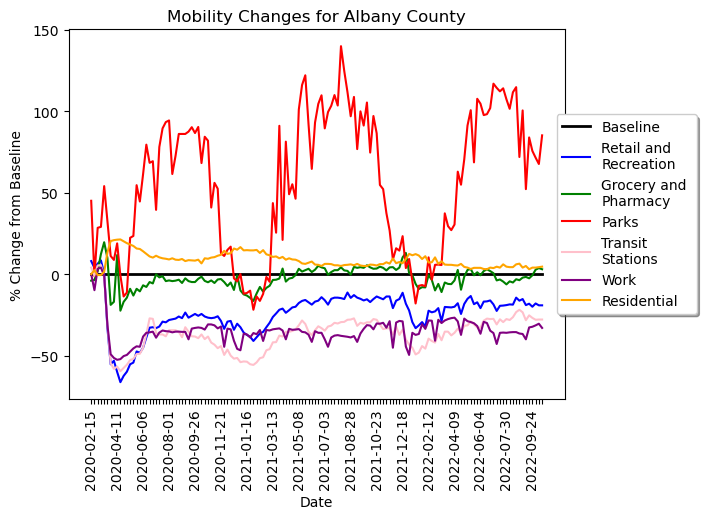

In [15]:
fig = plot_every_feature_for_county('Albany County')

In [12]:
def plot_every_county_for_feature(feature_index=3):
    """Returns a figure that represents a plot of every county's changes for a specified feature
        in the google mobility data. 

        3 = Retail and Recreation
        4 = Groceries and Pharmacies
        5 = Parks
        6 = Transit Stations
        7 = Work
        8 = Residential Areas
    Args:
        feature_index (str): index of the feature that is wanted. Mapping is described above.

    Returns:
        fig (matplotlib.figure.Figure): figure containing the resulting plot
    """
    feat_names = ['Retail and Recreation', 'Grocery and Pharmacy', 'Parks', 'Transit Stations', 'Work', 'Residential']
    feature = google_mobility_data_NY_cleaned.columns[feature_index]
    
    # Plot the baseline
    fig = plt.figure()
    plt.plot(google_mobility_data_NY_cleaned['date'], [0]*google_mobility_data_NY_cleaned.shape[0], label='Baseline', color='black', linewidth=2)
    
    # Plot each county
    for i, county in enumerate(google_mobility_data_NY_cleaned['county'].unique()):
        # Ensure all the dates are present for each county
        county_data = google_mobility_data_NY_cleaned[google_mobility_data_NY_cleaned['county'] == county]
            
        # Plot the results
        plt.plot(county_data['date'], county_data[feature], label=county)
        
    plt.xlabel('Date')
    plt.ylabel('% Change from Baseline')
    plt.title(f'New York {feat_names[feature_index - 3]} Mobility Changes ')
    #plt.legend(loc='best', ncol=5)
    plt.xticks(rotation=90)
    
    # Only keep every 8th tick
    for i, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
        if(i % 8 == 0):
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    return fig

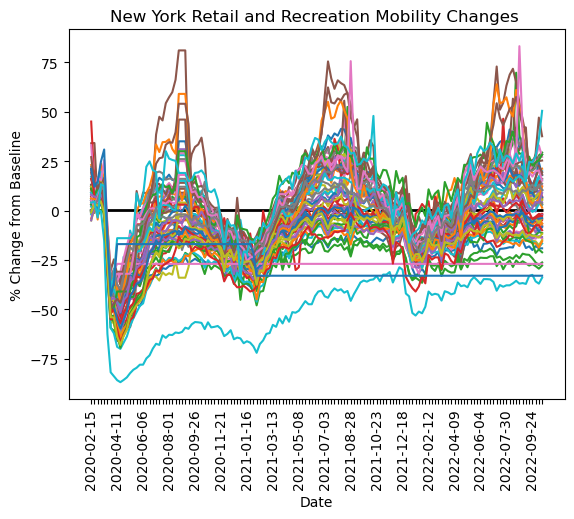

In [13]:
fig = plot_every_county_for_feature(feature_index=3)